# Face Generation using FaceNet and UNet-Style GAN

This notebook demonstrates a  face generation system that combines FaceNet for face embedding extraction and a UNet-style GAN for face generation. The system can generate realistic faces based on input face embeddings.

## Features
- Face embedding extraction using FaceNet
- High-quality face generation using UNet-style GAN
- Easy-to-use interface for inference
- Automatic model loading and management

## Setup and Dependencies
First, let's install the required packages:

In [1]:
!pip install facenet_pytorch huggingface_hub torch torchvision pillow matplotlib numpy --quiet

## Imports and Configuration

Let's import all the required libraries and set up a configuration dictionary for easy management of model parameters and paths.

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from facenet_pytorch import InceptionResnetV1
from huggingface_hub import hf_hub_download

# Configuration dictionary for all important parameters and paths
CONFIG = {
    "model": {
        "repo_id": "Mayank022/facegen-facenet-unet-gan-embedding",
        "generator_filename": "generator_epoch300.pt",
        "facenet_filename": "checkpoints/epoch_300/facenet_epoch300.pt",
        "subfolder": "checkpoints/epoch_300",
    },
    "model_params": {
        "embedding_dim": 512,
        "noise_dim": 128,
        "base_ch": 128,
        "img_ch": 3,
    },
    "image_size": 128,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

## Model Architecture

Below are the definitions for the key building blocks:
- Residual Upsampling Block (`ResBlockUp`)
- Self-Attention Block (`SelfAttention`)
- The main UNet-style Generator (`UNetStyleFusionGenerator`)

In [3]:
class ResBlockUp(nn.Module):
    """Residual block with upsampling for the generator."""
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        self.res = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False),
            nn.Upsample(scale_factor=2, mode='nearest')
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.up(x) + self.res(x)

class SelfAttention(nn.Module):
    """Self-attention module for the generator."""
    def __init__(self, in_dim: int):
        super().__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key   = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.size()
        q = self.query(x).view(B, -1, H * W).permute(0, 2, 1)
        k = self.key(x).view(B, -1, H * W)
        attn = torch.bmm(q, k).softmax(dim=-1)
        v = self.value(x).view(B, -1, H * W)
        out = torch.bmm(v, attn.permute(0, 2, 1)).view(B, C, H, W)
        return self.gamma * out + x

class UNetStyleFusionGenerator(nn.Module):
    """UNet-style generator with face embedding fusion."""
    def __init__(self, embedding_dim: int = 512, noise_dim: int = 128,
                 base_ch: int = 128, img_ch: int = 3):
        super().__init__()
        self.noise_dim = noise_dim
        self.base_ch = base_ch

        # Initial projection
        self.fc = nn.Linear(embedding_dim + noise_dim, base_ch * 8 * 4 * 4)

        # Embedding projections
        self.emb_proj = nn.ModuleList([
            nn.Linear(embedding_dim, base_ch * 8 * 8 * 8),
            nn.Linear(embedding_dim, base_ch * 4 * 16 * 16)
        ])

        # Upsampling blocks
        self.up1 = ResBlockUp(base_ch * 8, base_ch * 8)
        self.up2 = ResBlockUp(base_ch * 8, base_ch * 4)
        self.attn = SelfAttention(base_ch * 4)
        self.up3 = ResBlockUp(base_ch * 4, base_ch * 2)
        self.up4 = ResBlockUp(base_ch * 2, base_ch)
        self.up5 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(base_ch, img_ch, kernel_size=3, padding=1),
            nn.Tanh()
        )

        self.apply(self._init_weights)

    def forward(self, emb: torch.Tensor, batch_size: int = None) -> torch.Tensor:
        B = emb.size(0)
        if batch_size is None:
            batch_size = B

        # Generate noise and combine with embedding
        z = torch.randn(batch_size, self.noise_dim, device=emb.device)
        x = torch.cat([emb, z], dim=1)
        x = self.fc(x).view(B, self.base_ch * 8, 4, 4)

        # Process embeddings
        emb8 = self.emb_proj[0](emb).view(B, self.base_ch * 8, 8, 8)
        emb16 = self.emb_proj[1](emb).view(B, self.base_ch * 4, 16, 16)

        # Generator forward pass
        d1 = self.up1(x)
        d1 = d1 + emb8
        d2 = self.up2(d1)
        d2 = self.attn(d2 + emb16)
        d3 = self.up3(d2)
        d4 = self.up4(d3)
        out = self.up5(d4)

        return out

    @staticmethod
    def _init_weights(m: nn.Module) -> None:
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight, a=0.2)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.zeros_(m.bias)

## Model Loading and Inference Utilities

We define a `FaceGenerator` class that:
- Loads FaceNet and the generator model
- Handles preprocessing and postprocessing
- Provides a simple interface for generating and visualizing faces from an input image path

In [43]:
class FaceGenerator:
    """Main class for face generation pipeline."""
    def __init__(self, config):
        self.config = config
        self.device = torch.device(config['device'])
        self.facenet = None
        self.generator = None
        self.preprocess, self.postprocess = self._get_transforms()

    def _get_transforms(self):
        """Get preprocessing and postprocessing transforms."""
        preprocess = transforms.Compose([
            transforms.Resize((self.config['image_size'], self.config['image_size'])),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
        postprocess = transforms.Compose([
            transforms.Normalize(mean=[-1]*3, std=[2]*3),
            transforms.ToPILImage()
        ])
        return preprocess, postprocess

    def load_models(self):
        """Load FaceNet and Generator models."""
        # Load FaceNet
        facenet_ckpt_path = hf_hub_download(
            repo_id=self.config['model']['repo_id'],
            filename=self.config['model']['facenet_filename']
        )
        raw_ckpt = torch.load(facenet_ckpt_path, map_location=self.device)
        cleaned_ckpt = {k: v for k, v in raw_ckpt.items() if not k.startswith("logits.")}
        self.facenet = InceptionResnetV1(pretrained=None, classify=False).to(self.device)
        self.facenet.load_state_dict(cleaned_ckpt, strict=False)
        self.facenet.eval()

        # Load Generator
        generator_ckpt_path = hf_hub_download(
            repo_id=self.config['model']['repo_id'],
            filename=self.config['model']['generator_filename'],
            subfolder=self.config['model']['subfolder']
        )
        self.generator = UNetStyleFusionGenerator(**self.config['model_params']).to(self.device)
        self.generator.load_state_dict(torch.load(generator_ckpt_path, map_location=self.device))
        self.generator.eval()

    def generate_face(self, image_path):
        """Generate a face from an input image.

        Args:
            image_path: Path to the input image

        Returns:
            Tuple containing (original_image, generated_image, face_embedding)
        """
        if self.facenet is None or self.generator is None:
            self.load_models()

        # Load and preprocess image
        img_pil = Image.open(image_path).convert('RGB')
        input_tensor = self.preprocess(img_pil).unsqueeze(0).to(self.device)

        # Get FaceNet embedding and generate image
        with torch.no_grad():
            embedding = self.facenet(input_tensor)
            generated = self.generator(embedding)

        # Convert to PIL
        orig_img = self.postprocess(input_tensor.squeeze().cpu())
        gen_img = self.postprocess(generated.squeeze().cpu())

        return orig_img, gen_img, embedding

    def visualize_results(self, orig_img, gen_img, embedding=None):
        # Display at true 128x128 pixel size (no upscaling)
        dpi = 80  # typical screen dpi
        img_size = 128
        fig_w = 2 * img_size / dpi
        fig_h = img_size / dpi

        fig, axes = plt.subplots(1, 2, figsize=(fig_w, fig_h), dpi=dpi)

        axes[0].imshow(orig_img)
        axes[0].set_title("Original Face")
        axes[0].axis("off")

        axes[1].imshow(gen_img)
        axes[1].set_title("Generated Face")
        axes[1].axis("off")

        plt.subplots_adjust(wspace=0.05, hspace=0)
        plt.show()

        if embedding is not None:
            print("\nFaceNet Embedding (first 20 dimensions):")
            print(torch.round(embedding.squeeze()[:20] * 1000) / 1000)

## Usage Example

Here's how to use the face generation pipeline.  
Just provide the path to your image, and the model will handle everything else!

In [44]:
# Initialize the face generator
face_gen = FaceGenerator(CONFIG)

# Function to process and visualize a face image
def process_image(image_path):
    orig_img, gen_img, embedding = face_gen.generate_face(image_path)
    face_gen.visualize_results(orig_img, gen_img, embedding)

# Example usage (replace with your own image path)
# process_image("path/to/your/face/image.jpg")

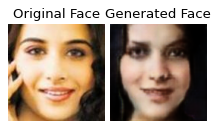


FaceNet Embedding (first 20 dimensions):
tensor([ 0.0120,  0.0630,  0.0370,  0.0600, -0.0250, -0.0050, -0.0000,  0.0330,
         0.0090, -0.0400,  0.0040, -0.0570, -0.0300, -0.0380, -0.0110, -0.0760,
        -0.0040, -0.0630, -0.0210,  0.0510])


In [84]:
process_image("test_6.jpg")

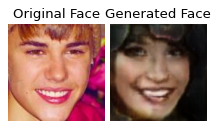


FaceNet Embedding (first 20 dimensions):
tensor([ 0.0080,  0.0120,  0.0030,  0.0400,  0.0120, -0.0100,  0.0060,  0.0730,
        -0.0150, -0.0070,  0.0560, -0.0470, -0.0200, -0.0050,  0.0140, -0.0330,
        -0.0570, -0.0670, -0.0130,  0.0400])


In [155]:
process_image("test_image_7.jpg")